In [1]:
import sys
sys.path.append('../src')
from utils import run_simulation, read_openfoam_field

import os
import numpy as np
import pandas as pd

from jinja2 import Environment, FileSystemLoader

import subprocess
import os

import json

from tqdm import tqdm
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import gaussian_kde

Setup Variables

In [22]:
base_case_directory = "../simulator/base_cases/Scenario_4_C1_Lyu"

# foil_model = 'stars'
foil_model = 'eclipse'
# foil_model = 'namdar'

latex = ['floil', 'fmoil', 'epoil']

nsamples = 100
nthreads = 5

quantile_hdi = 0.95

experiment_name = f'foil_lyu2021_c4_{foil_model}'

In [23]:
feasible_space = pd.read_csv(f'../data/traces/trace_lyu2021simulationc4_synth_high_{foil_model}.csv')
feasible_space.describe()

,fmoil,epoil
count,200000.000000,200000.000000
mean,0.680476,4.697358
std,0.206548,7.429687
min,0.010329,0.442693
25%,0.521093,2.551458
50%,0.706768,3.699587
75%,0.858036,4.950885
max,0.989999,99.971246


In [29]:
data_matrix = feasible_space.values.T

kde = gaussian_kde(data_matrix)
densities = kde(data_matrix)

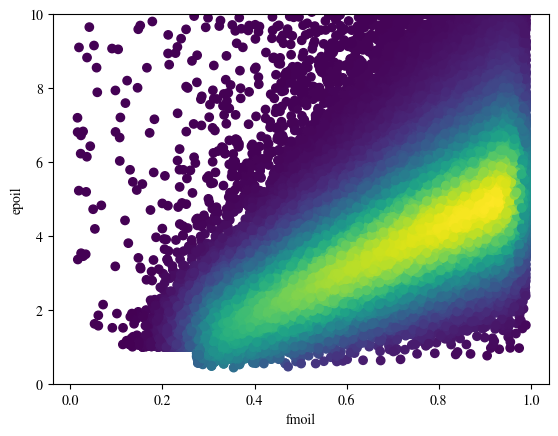

In [30]:
if foil_model == 'stars':
    fig = go.Figure(data=[go.Scatter3d(
        x=data_matrix[0],
        y=data_matrix[1],
        z=data_matrix[2],
        mode='markers',
        marker=dict(
            size=5,
            color=densities,
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title=latex[0],
            yaxis_title=latex[1],
            zaxis_title=latex[2]
        ),
        font=dict(
            family="STIXGeneral",
            size=12,
            color="black"
        )
    )

    fig.write_html(f"../data/plots/feasible_space_{foil_model}.html")
    # fig.show()
    print('Saved plot to ../data/plots/feasible_space_stars.html')
else:
    
    fig, ax = plt.subplots()
    ax.scatter(data_matrix[0], data_matrix[1], c=densities, cmap='viridis')
    ax.set_xlabel(latex[1])
    ax.set_ylabel(latex[2])
    if foil_model == 'eclipse':
        ax.set_ylim(0, 10)
    plt.savefig(f"../data/plots/feasible_space_{foil_model}.pdf")

In [31]:
sorted_indices = np.argsort(densities)[::-1]
sorted_densities = densities[sorted_indices]
sorted_data = data_matrix[:, sorted_indices]

cumulative_density = np.cumsum(sorted_densities) / np.sum(sorted_densities)
hdi_threshold = np.where(cumulative_density >= quantile_hdi)[0][0]

hdi_points = sorted_data[:, :hdi_threshold + 1]
hdi_densities = sorted_densities[:hdi_threshold + 1]

hdi_df = pd.DataFrame(hdi_points.T, columns=feasible_space.columns)

In [32]:
hdi_df = pd.DataFrame(hdi_points.T, columns=feasible_space.columns)

np.random.seed(33)

print(f'Filtered {hdi_df.shape[0]} rows from a trace of {feasible_space.shape[0]} samples.')

X_ED = hdi_df.sample(nsamples).values
# X_ED

Filtered 167886 rows from a trace of 200000 samples.


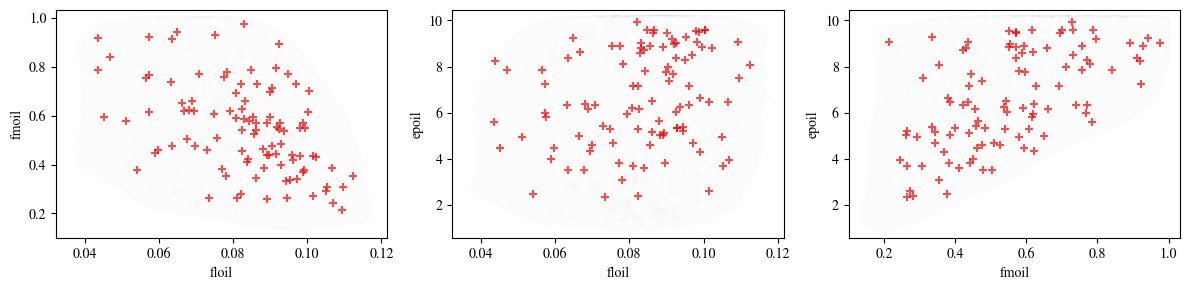

In [8]:
if foil_model == 'stars':
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    # Scatter plot for each pair of variables
    for ii, (i, j) in enumerate([(0, 1), (0, 2), (1, 2)]):
        axs[ii].scatter(hdi_df[latex[i]], hdi_df[latex[j]], c=hdi_densities, cmap='Greys', alpha=0.3)
        axs[ii].scatter(X_ED[:, i], X_ED[:, j], c='red', alpha=0.7, marker='+')
        axs[ii].set_xlabel(latex[i])
        axs[ii].set_ylabel(latex[j])

    plt.tight_layout()
    plt.savefig(f"../data/plots/feasible_space_{foil_model}_samples.pdf")
else:
    fig, ax = plt.subplots()
    # scatter plot 2D with matplotlib
    ax.scatter(hdi_df[latex[1]], hdi_df[latex[2]], c=hdi_densities, cmap='Greys', alpha=0.3)
    ax.scatter(X_ED[:, 0], X_ED[:, 1], c='red', alpha=0.7, marker='+')
    plt.xlabel(latex[1])
    plt.ylabel(latex[2])
    plt.title(f'{foil_model.capitalize()} Feasible Space and Samples')

    plt.savefig(f"../data/plots/feasible_space_{foil_model}_samples.pdf")


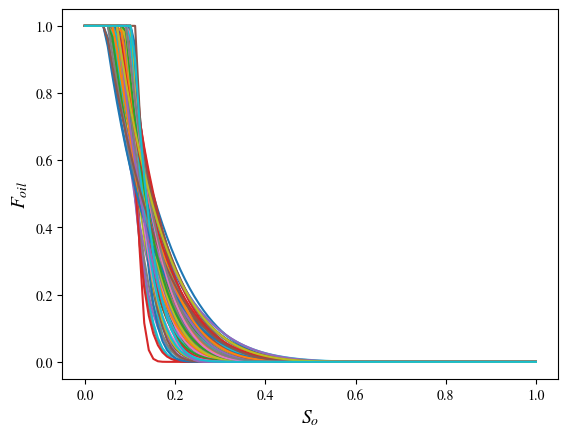

In [9]:
def foil(floil, fmoil, epoil):
    
    xpto = np.linspace(0, 1, 100)
    
    if foil_model == 'namdar':
        Fo = 0.5 + ( np.arctan( epoil * (fmoil - xpto) ) ) / np.pi 
    else:
        Fo = (
            (xpto <= fmoil) * (   # if so > fmoil, Fo = 0
                (fmoil - xpto)/(fmoil - floil)
            ) ** (xpto >= floil)  # if so < floil, Fo = 1
        )**epoil
    
    return Fo

for xed in X_ED:
    if foil_model != 'stars':
        xed = [0.0, xed[0], xed[1]]
    plt.plot(np.linspace(0, 1, 100), foil(*xed))

plt.xlabel(r'$S_o$', fontsize=14)
plt.ylabel(r'$F_{oil}$', fontsize=14)
plt.savefig(f"../data/plots/foil_samples_{foil_model}.pdf")

In [10]:
# XXX Testing run_simulation function
base_case_directory = "../simulator/base_cases/Scenario_4_C1_Lyu"
experiment_name = "teste02"

# run_simulation(base_case_directory, experiment_name, floil=0.2, fmoil=0.5, epoil=2)

___
### Sampling

<span style="color:red">**WARNING!**</span>

**Do not run this section if your sampling has already been done.**

In [11]:
# def process_simulation(params, base_case_directory, foil_model):
#     i, (floil, fmoil, epoil) = params
#     experiment_name = f"foil_lyu2021_c4_{foil_model}/sample_{i:03d}"
#     run_simulation(base_case_directory, experiment_name, floil=floil, fmoil=fmoil, epoil=epoil, verbose=False)

# process_func = partial(
#     process_simulation, 
#     base_case_directory=base_case_directory, 
#     foil_model=foil_model
# )

# if foil_model == 'stars':
#     params = list(enumerate(X_ED))
# else:
#     params = list(enumerate( np.hstack([np.zeros((nsamples, 1)), X_ED]) ))

# with Pool(nthreads) as pool:
#     for _ in tqdm(
#         pool.imap_unordered(process_func, params),
#         total=len(params), 
#         desc='Running simulations',
#         mininterval=1.0     # Updates at most once per second
#     ):
#         pass


___

## Reading the Sampled Simulations

In [12]:
# # XXX old version, slower
# def read_openfoam_field(file_path):
#     """
#     Reads an OpenFOAM field file and returns its data.
    
#     Parameters:
#         file_path (str): Path to the OpenFOAM field file.
        
#     Returns:
#         numpy.ndarray: Array of field values.
#     """
    
#     with open(file_path, 'r') as f:
#         # Skip to the 'internalField' section
#         while True:
#             line = f.readline()
#             if line.startswith('internalField'):
#                 break

#         # Skip to data start, typically after "nonuniform List"
#         while True:
#             line = f.readline().strip()
#             if line.isdigit():
#                 num_elements = int(line)
#                 f.readline()  # Skip opening parenthesis "("
#                 break

#         values = []
#         for _ in range(num_elements):
#             line = f.readline().strip().strip('()')
#             if ' ' in line:
#                 values.append(np.fromstring(line, sep=' '))
#             else:
#                 values.append(float(line))

#     return np.array(values)

In [25]:
case_dir = f'../simulator/experiments/foil_lyu2021_c4_{foil_model}/sample_015'

# openfoam_data = read_openfoam_field(os.path.join(case_dir, '200', 'Sa') )

In [14]:
def parse_openfoam_case(case_dir, variables=['p', 'Sa', 'Sb', 'U', 'Ua', 'Ub', 'Uc']):
    """
    Parses the OpenFOAM case directory structure and reads all field data.
    
    Parameters:
        case_dir (str): Path to the root directory of the OpenFOAM case.
        variables (list): List of field names to read. 
            Default is pressure ('p'), Saturations ('Sa', 'Sb'), and velocities ('U', 'Ua', 'Ub', 'Uc').
        
    Returns:
        dict: Nested dictionary where keys are time directories and field names.
    """
    data = {}

    # Iterate over time directories, e.g. '50', '100', '200', ...
    time_dirs = [d for d in os.listdir(case_dir) if d.isdigit() and int(d) > 0]
    time_dirs = sorted(time_dirs, key=lambda x: int(x))

    for time_dir in time_dirs:
        
        time_path = os.path.join(case_dir, time_dir)

        if not os.path.isdir(time_path):
            continue

        data[time_dir] = {}

        # Iterate over field/var files in the time directory, e.g. 'U', 'p', 'S', ...
        for field_file in variables:

            field_path = os.path.join(time_path, field_file)
            if os.path.isfile(field_path):
                try:
                    data[time_dir][field_file] = read_openfoam_field(field_path)
                    # print(f"Read {field_file} from {time_dir}")
                except Exception as e:
                    print(f"Error reading {field_file} in {time_dir}: {e}")

    data = {field: {time: data[time][field] for time in data} for field in data['50']}

    return data

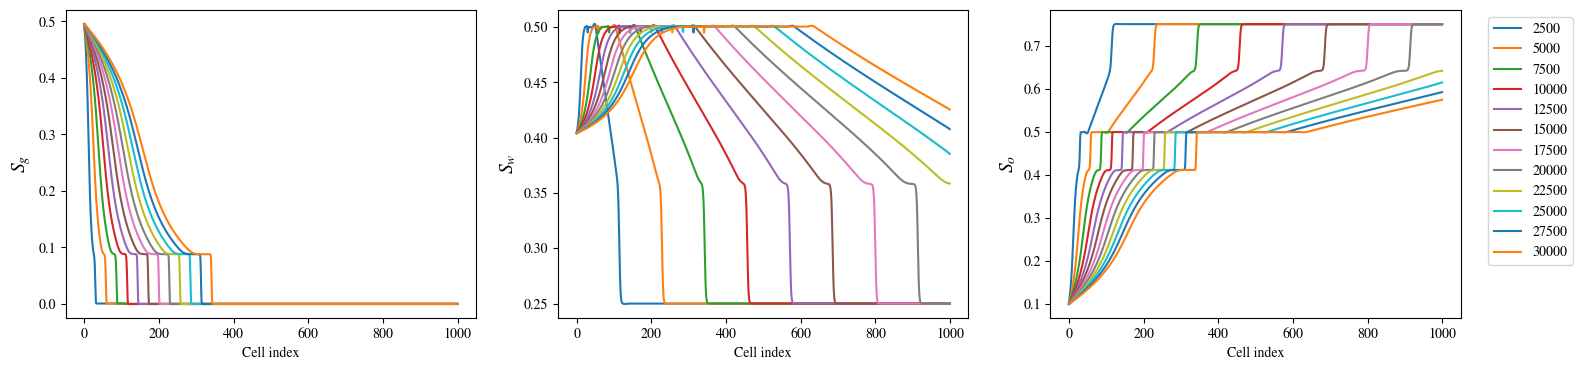

In [26]:
data_dict = parse_openfoam_case(case_dir)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

for (time, Sas), Sbs in list(zip(data_dict['Sa'].items(), data_dict['Sb'].values()))[49::50]:
    ax1.plot(Sas, label=time)
    ax2.plot(Sbs, label=time)

    So = 1 - Sas - Sbs
    ax3.plot(So, label=time)


ax1.set_ylabel(r'$S_g$', fontsize=14)
ax1.set_xlabel('Cell index')

ax2.set_ylabel(r'$S_w$', fontsize=14)
ax2.set_xlabel('Cell index')

ax3.set_ylabel(r'$S_o$', fontsize=14)
ax3.set_xlabel('Cell index')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f"../data/plots/saturations_{foil_model}.pdf")

In [ ]:
def read_openfoam_field(file_path):
    """
    Reads an OpenFOAM ASCII field file and returns its data.
    
    Parameters:
        file_path (str): Path to the OpenFOAM field file.
        
    Returns:
        numpy.ndarray: Array of field values.
    """
    with open(file_path, 'r') as f:
        # Skip to the 'internalField' section
        while True:
            line = f.readline()
            if line.startswith('internalField'):
                break

        # Skip to data start, typically after "nonuniform List"
        while True:
            line = f.readline().strip()
            if line.isdigit():
                num_elements = int(line)
                f.readline()  # Skip opening parenthesis "("
                break

        values = []
        for _ in range(num_elements):
            line = f.readline().strip().strip('()')
            if ' ' in line:
                values.append(np.fromstring(line, sep=' '))
            else:
                values.append(float(line))

    return np.array(values)


In [ ]:
case_dir = '../data/sim_openfoam'

openfoam_data = read_openfoam_field(os.path.join(case_dir, '200', 'Sa') )

In [ ]:
def parse_openfoam_case(case_dir):
    """
    Parses the OpenFOAM case directory structure and reads all field data.
    
    Parameters:
        case_dir (str): Path to the root directory of the OpenFOAM case.
        
    Returns:
        dict: Nested dictionary where keys are time directories and field names.
    """
    data = {}

    # Iterate over time directories, e.g. '0', '100', '200', ...
    for time_dir in os.listdir(case_dir):

        if time_dir == '0' or not time_dir.isdigit():
            continue
        
        time_path = os.path.join(case_dir, time_dir)

        if not os.path.isdir(time_path):
            continue

        data[time_dir] = {}

        # Iterate over field/var files in the time directory, e.g. 'U', 'p', 'S', ...
        for field_file in os.listdir(time_path):

            if not field_file.startswith('U') and not field_file.startswith('S') and not field_file == 'p':
                continue

            field_path = os.path.join(time_path, field_file)
            if os.path.isfile(field_path):
                try:
                    data[time_dir][field_file] = read_openfoam_field(field_path)
                    # print(f"Read {field_file} from {time_dir}")
                except Exception as e:
                    print(f"Error reading {field_file} in {time_dir}: {e}")

    return data

data_dict = parse_openfoam_case(case_dir)

In [ ]:
case_dir = '../data/Lyu_C4'
data_dict = parse_openfoam_case(case_dir)

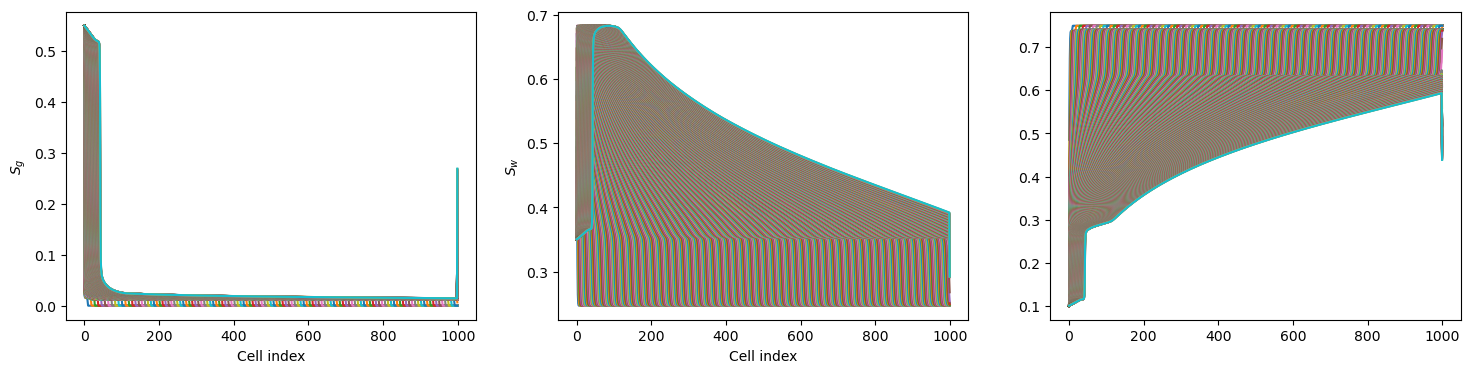

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

data_dict = dict(sorted(data_dict.items(), key=lambda x: float(x[0])))

for time, fields in data_dict.items():
    for field_name, field_data in fields.items():
        if field_name == 'Sa':
            Sas = field_data
            ax1.plot(field_data, label=time)

        if field_name == 'Sb':
            Sbs = field_data
            ax2.plot(field_data, label=time)

    So = 1 - Sas - Sbs
    ax3.plot(So, label=time)



ax1.set_ylabel(r'$S_g$')
ax1.set_xlabel('Cell index')

ax2.set_ylabel(r'$S_w$')
ax2.set_xlabel('Cell index')

ax3.set_ylabel(r'$S_o$')
ax3.set_xlabel('Cell index')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import subprocess
import os

# Function to run the simulator
def run_simulator():
    sim_dir = os.path.join('simulator', 'Examples', 'Scenario_4_C1_Lyu')
    command = './impesFoam3ph_v1'
    
    # Change to the simulator directory and run the command
    result = subprocess.run(command, cwd=sim_dir, shell=True, capture_output=True, text=True)
    
    # Print the output and error (if any)
    print(result.stdout)
    if result.stderr:
        print(result.stderr)


In [ ]:
# get the mean saturation for each time step
mean_Sa = []
mean_Sb = []

for time, fields in data_dict.items():
    Sa = fields['Sa']
    Sb = fields['Sb']
    # mean_Sa.append(np.mean(Sa))
    # mean_Sb.append(np.mean(Sb))
    mean_Sa.append(Sa[10])
    mean_Sb.append(Sb[10])

gas_path = np.array(mean_Sa)
water_path = np.array(mean_Sb)
oil_path = 1 - gas_path - water_path

In [ ]:
def foil_k(so, floil, fmoil, epoil):
    Fo = (
        (so <= fmoil) * (   # if so > fmoil, Fo = 0
            (fmoil - so)/(fmoil - floil)
        ) ** (so >= floil)  # if so < floil, Fo = 1
    )**epoil
    return Fo

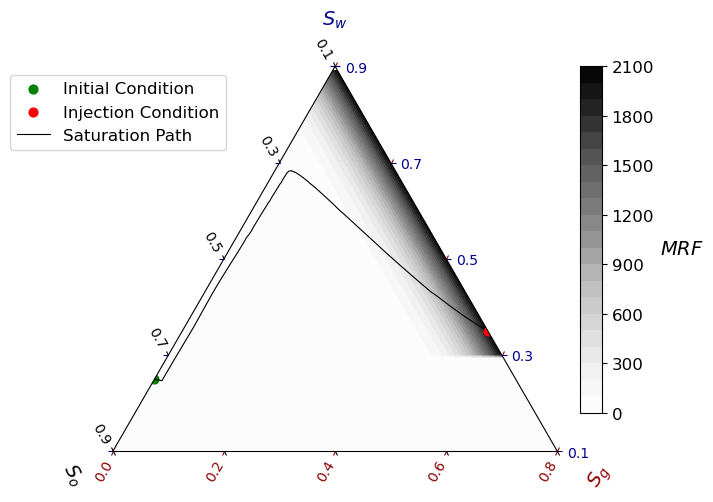

In [ ]:
import mpltern

Swc = 0.1
Sor = 0.1
Sgr = 0.0

# fmmob = 1859
# fmdry = 0.39
# epdry = 1000
fmmob = 2000
fmdry = 0.3
epdry = 32_000

floil, fmoil, epoil = 0.1, 0.3, 3

swx = np.linspace(Swc, 1 - Sgr - Sor, 100)
sox = np.linspace(Sor, 1 - Swc - Sgr, 100)
sw, so = np.meshgrid(swx, sox)

sw = sw.flatten()
so = so.flatten()
sg = 1 - sw - so

# Apply mask to keep only valid points
mask = (sw >= Swc) & (so >= Sor) & (sg >= Sgr) & (sw + so + sg <= 1)
sw, so, sg = sw[mask], so[mask], sg[mask]

Fo = foil_k( so, floil=floil, fmoil=fmoil, epoil=epoil)
Fw = 0.5 + np.arctan( epdry * (sw - fmdry) ) / np.pi
mrf = 1 + fmmob * Fw * Fo

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='ternary')

tcf1 = ax.tricontourf(sw, so, sg, mrf, cmap='Greys', levels=20)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
cbar1 = fig.colorbar(tcf1, cax=cax)
cbar1.set_label('$MRF$', fontsize=14, rotation=0, labelpad=20)
cbar1.ax.tick_params(labelsize=12)

ax.scatter(0.25, 0.75, 0.00, c='green', s=40, marker='o', label='Initial Condition')
ax.scatter(0.35, 0.10, 0.55, c='red', s=40, marker='o', label='Injection Condition')

ax.plot(water_path, oil_path, gas_path, c='black', lw=0.8, label='Saturation Path')

sw_range = [Swc, 1 - Sgr - Sor]
so_range = [Sor, 1 - Swc - Sgr]
sg_range = [Sgr, 1 - Swc - Sor]

ax.set_tlabel('$S_w$', fontsize=14, rotation=0)
ax.set_llabel('$S_o$', fontsize=14, rotation=0)
ax.set_rlabel('$S_g$', fontsize=14, rotation=0)

ax.set_tlim(sw_range[0], sw_range[1])
ax.set_llim(so_range[0], so_range[1])
ax.set_rlim(sg_range[0], sg_range[1])

ax.taxis.set_ticks(np.linspace(*sw_range, 5))
ax.laxis.set_ticks(np.linspace(*so_range, 5))
ax.raxis.set_ticks(np.linspace(*sg_range, 5))

ax.taxis.set_tick_params(tick2On=True, colors='darkblue', grid_color='darkblue')
ax.laxis.set_tick_params(tick2On=True, colors='k', grid_color='k')
ax.raxis.set_tick_params(tick2On=True, colors='darkred', grid_color='darkred')

ax.taxis.label.set_color('darkblue')
ax.laxis.label.set_color('k')
ax.raxis.label.set_color('darkred')

plt.legend( loc='upper left', bbox_to_anchor=(-.25, 1), fontsize=12)

In [34]:
for ii, xed in enumerate(X_ED):
    print (ii, xed)

0 [0.58170489 2.44139777]
1 [0.39739493 1.60790604]
2 [0.44492863 2.08254485]
3 [0.37123482 1.90654578]
4 [0.88975122 4.40658497]
5 [0.89452379 4.2126346 ]
6 [0.59373263 3.3948616 ]
7 [0.70335594 2.66724972]
8 [0.57820368 3.27852845]
9 [0.89989499 5.04974653]
10 [0.93845032 4.89477473]
11 [0.90420617 5.90300607]
12 [0.64522196 3.41939405]
13 [0.91894248 3.99219681]
14 [0.44674738 2.51368892]
15 [0.68515109 3.79759716]
16 [0.55390317 3.06689618]
17 [0.75233505 5.55326086]
18 [0.3224787 1.8947306]
19 [0.81784341 3.53294585]
20 [0.49261984 2.88217236]
21 [0.30327587 0.8872637 ]
22 [0.64468013 2.69169701]
23 [0.69184321 3.36660101]
24 [0.98055246 5.88368805]
25 [0.35865127 0.69391751]
26 [0.78316995 5.92927036]
27 [0.48629575 2.20631709]
28 [0.79637751 4.62057774]
29 [0.74788571 4.20980063]
30 [0.51911892 2.81381089]
31 [0.94618373 4.76086806]
32 [0.82236436 4.69863319]
33 [0.32967005 1.13833418]
34 [0.80819415 3.82624177]
35 [0.64216805 2.67689488]
36 [0.64637491 2.37013636]
37 [0.6816634

In [ ]:
water_paths = []
oil_paths = []
gas_paths = []

sampled_samples = [0, 15, 30]

for i in sampled_samples:
    case_dir = f'../simulator/experiments/foil_lyu2021_c4_{foil_model}/sample_{i:03d}'
    data_dict = parse_openfoam_case(case_dir)

    # get the mean saturation for each time step
    mean_Sa = []
    mean_Sb = []

    for Sa, Sb in zip(data_dict['Sa'].values(), data_dict['Sb'].values()):
        # mean_Sa.append(np.mean(Sa))
        # mean_Sb.append(np.mean(Sb))
        mean_Sa.append(Sa[10])
        mean_Sb.append(Sb[10])

    water_path = np.array(mean_Sb)
    gas_path = np.array(mean_Sa)
    oil_path = 1 - gas_path - water_path

    water_paths.append(water_path)
    oil_paths.append(oil_path)
    gas_paths.append(gas_path)

In [36]:
def foil_aux(so, floil, fmoil, epoil):
    
    if foil_model == 'namdar':
        Fo = 0.5 + ( np.arctan( epoil * (fmoil - so) ) ) / np.pi 
    else:
        Fo = (
            (so <= fmoil) * (   # if so > fmoil, Fo = 0
                (fmoil - so)/(fmoil - floil)
            ) ** (so >= floil)  # if so < floil, Fo = 1
        )**epoil
    
    return Fo

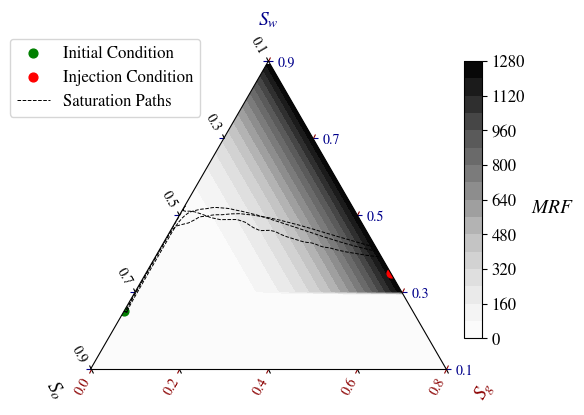

In [45]:
import mpltern

Swc = 0.1
Sor = 0.1
Sgr = 0.0

# fmmob = 1859
# fmdry = 0.39
# epdry = 1000
fmmob = 2000
fmdry = 0.3
epdry = 32_000

if foil_model == 'stars':
    floil, fmoil, epoil = 0.1, 0.3, 3
elif foil_model == 'eclipse':
    floil, fmoil, epoil = 0.0, 0.581, 2.441
elif foil_model == 'namdar':
    floil, fmoil, epoil = 0.0, 0.125, 50

swx = np.linspace(Swc, 1 - Sgr - Sor, 100)
sox = np.linspace(Sor, 1 - Swc - Sgr, 100)
sw, so = np.meshgrid(swx, sox)

sw = sw.flatten()
so = so.flatten()
sg = 1 - sw - so

# Apply mask to keep only valid points
mask = (sw >= Swc) & (so >= Sor) & (sg >= Sgr) & (sw + so + sg <= 1)
sw, so, sg = sw[mask], so[mask], sg[mask]

Fo = foil_aux( so, floil=floil, fmoil=fmoil, epoil=epoil)
Fw = 0.5 + np.arctan( epdry * (sw - fmdry) ) / np.pi
mrf = 1 + fmmob * Fw * Fo

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111, projection='ternary')

tcf1 = ax.tricontourf(sw, so, sg, mrf, cmap='Greys', levels=20)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
cbar1 = fig.colorbar(tcf1, cax=cax)
cbar1.set_label('$MRF$', fontsize=14, rotation=0, labelpad=20)
cbar1.ax.tick_params(labelsize=12)

ax.scatter(0.25, 0.75, 0.00, c='green', s=40, marker='o', label='Initial Condition')
ax.scatter(0.35, 0.10, 0.55, c='red', s=40, marker='o', label='Injection Condition')


ax.plot(water_paths[0], oil_paths[0], gas_paths[0], '--', c='black', lw=0.7, label='Saturation Paths')
for ii in range(1, len(water_paths)):
    ax.plot(water_paths[ii], oil_paths[ii], gas_paths[ii], '--', c='black', lw=0.7)


sw_range = [Swc, 1 - Sgr - Sor]
so_range = [Sor, 1 - Swc - Sgr]
sg_range = [Sgr, 1 - Swc - Sor]

ax.set_tlabel('$S_w$', fontsize=14, rotation=0)
ax.set_llabel('$S_o$', fontsize=14, rotation=0)
ax.set_rlabel('$S_g$', fontsize=14, rotation=0)

ax.set_tlim(sw_range[0], sw_range[1])
ax.set_llim(so_range[0], so_range[1])
ax.set_rlim(sg_range[0], sg_range[1])

ax.taxis.set_ticks(np.linspace(*sw_range, 5))
ax.laxis.set_ticks(np.linspace(*so_range, 5))
ax.raxis.set_ticks(np.linspace(*sg_range, 5))

ax.taxis.set_tick_params(tick2On=True, colors='darkblue', grid_color='darkblue')
ax.laxis.set_tick_params(tick2On=True, colors='k', grid_color='k')
ax.raxis.set_tick_params(tick2On=True, colors='darkred', grid_color='darkred')

ax.taxis.label.set_color('darkblue')
ax.laxis.label.set_color('k')
ax.raxis.label.set_color('darkred')

plt.legend( loc='upper left', bbox_to_anchor=(-.25, 1.1), fontsize=12)
plt.savefig(f"../data/plots/ternary_{foil_model}.pdf")